# Step-by-Step Analysis of a Stable Diffusion Model

This notebook walks through the components and processes of a Stable Diffusion model, based on the provided Python implementation. We will explore:
1. Model Setup and Loading.
2. Deep dive into individual components: CLIP Text Encoder, VAE (Encoder & Decoder), and the Diffusion U-Net.
3. The forward diffusion (noising) process.
4. The full reverse diffusion (denoising/generation) pipeline.
5. Visualizations at various stages to aid understanding.

Shoutout to Umar Jamil for giving the youtube tutorial for stable diffusion method clearly for 5 hours.

Link: https://youtu.be/ZBKpAp_6TGI?si=Ec3-FdMPBgMHkwU6

Github: https://github.com/hkproj/pytorch-stable-diffusion

## I. Setup and Model Loading

### Imports and Environment Configuration

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm 
import math
import torch.nn.functional as F 
from pathlib import Path 

import model_loader
import pipeline
import ddpm
from model_loader import preload_models_from_standard_weights
from pipeline import generate, rescale, get_time_embedding, WIDTH, HEIGHT, LATENTS_WIDTH, LATENTS_HEIGHT
from clip import CLIP
from encoder import VAE_Encoder
from decoder import VAE_Decoder
from diffusion import Diffusion, TimeEmbedding, UNET_ResidualBlock, UNET_AttentionBlock
from ddpm import DDPMSampler

from transformers import CLIPTokenizer

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

CKPT_PATH = "../data/v1-5-pruned-emaonly.ckpt"

IDLE_DEVICE = "cpu" if torch.cuda.is_available() else None 

c:\Users\Lenovo\.conda\envs\stable_diff_model\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


### Load Pre-trained Models

We'll use the preload_models_from_standard_weights function, which internally uses model_converter.py to map weights from a standard checkpoint to our model definitions. 

**Note:** Ensure your model_converter.py has the complete and correct mappings for your checkpoint version.

In [ ]:
try:
    models = preload_models_from_standard_weights(CKPT_PATH, DEVICE)
    print("Models loaded successfully!")
    for model_name, model_obj in models.items():
        print(f"- {model_name} on device: {next(model_obj.parameters()).device}")
except FileNotFoundError:
    print(f"ERROR: Checkpoint file not found at {CKPT_PATH}. Please update the path.")
    models = None 
except Exception as e:
    print(f"An error occurred during model loading: {e}")
    print("This might be due to an incomplete or incorrect 'model_converter.py' or an incompatible checkpoint file.")
    models = None

Models loaded successfully!
- clip on device: cuda:0
- encoder on device: cuda:0
- decoder on device: cuda:0
- diffusion on device: cuda:0


### Load CLIP Tokenizer

In [3]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

c:\Users\Lenovo\.conda\envs\stable_diff_model\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## II. Understanding the Components

### A. Text Encoder (CLIP)

The CLIP model converts text prompts into numerical embeddings that guide the image generation process.

#### A.1 Tokenization

In [ ]:
sample_prompt = "A photo of an astronaut riding a horse on the moon"
uncond_prompt = "" # Empty prompt for unconditional guidance

# Tokenize the prompt
cond_tokens_data = tokenizer.batch_encode_plus(
    [sample_prompt],
    padding="max_length", 
    max_length=77, # Standard sequence length for CLIP in Stable Diffusion
    truncation=True, # Ensure truncation if prompt is too long
    return_tensors="pt" # Return PyTorch tensors
)
cond_token_ids = cond_tokens_data.input_ids.to(DEVICE)

uncond_tokens_data = tokenizer.batch_encode_plus(
    [uncond_prompt],
    padding="max_length", 
    max_length=77,
    truncation=True,
    return_tensors="pt"
)
uncond_token_ids = uncond_tokens_data.input_ids.to(DEVICE)

print(f"Sample Prompt: '{sample_prompt}'")
print(f"Token IDs shape: {cond_token_ids.shape}") # Expected: (Batch_Size, Seq_Len) -> (1, 77)
print(f"First 10 Token IDs: {cond_token_ids[0, :10]}")

# You can decode to see the tokens, including special ones like <|startoftext|> and <|endoftext|>
decoded_tokens = [tokenizer.decode([token_id]) for token_id in cond_token_ids[0].tolist()]
print(f"Decoded tokens (first 10): {decoded_tokens[:10]}")

Sample Prompt: 'A photo of an astronaut riding a horse on the moon'
Token IDs shape: torch.Size([1, 77])
First 10 Token IDs: tensor([49406,   320,  1125,   539,   550, 18376,  6765,   320,  4558,   525],
       device='cuda:0')
Decoded tokens (first 10): ['<|startoftext|>', 'a', 'photo', 'of', 'an', 'astronaut', 'riding', 'a', 'horse', 'on']


#### A.2 Token and Positional Embeddings

Token embeddings shape: torch.Size([1, 77, 768])
Positional embeddings shape: torch.Size([77, 768])
Initial CLIP input (after adding pos_embed) shape: torch.Size([1, 77, 768])


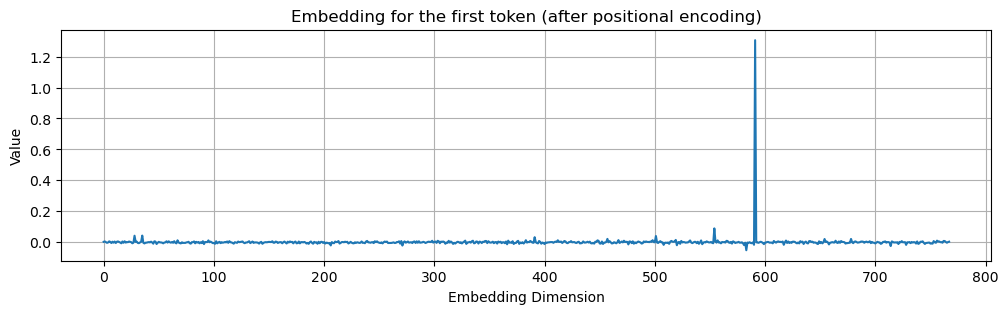

In [5]:
if models:
    clip_model = models['clip']
    clip_embedding_layer = clip_model.embedding

    # Get token embeddings
    token_embeddings = clip_embedding_layer.token_embedding(cond_token_ids)
    print(f"Token embeddings shape: {token_embeddings.shape}") # Expected: (Batch_Size, Seq_Len, Dim) -> (1, 77, 768)

    # Get positional embeddings
    positional_embeddings = clip_embedding_layer.position_embedding
    print(f"Positional embeddings shape: {positional_embeddings.shape}") # Expected: (Seq_Len, Dim) -> (77, 768)

    # The final input to CLIP layers is the sum of token and positional embeddings
    initial_clip_input = token_embeddings + positional_embeddings
    print(f"Initial CLIP input (after adding pos_embed) shape: {initial_clip_input.shape}")

    # Visualize a slice of the embeddings (e.g., first token's embedding)
    plt.figure(figsize=(12, 3))
    plt.plot(initial_clip_input[0, 0, :].cpu().detach().numpy())
    plt.title("Embedding for the first token (after positional encoding)")
    plt.xlabel("Embedding Dimension")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()
else:
    print("Models not loaded, skipping CLIP embedding visualization.")

#### A.3 CLIP Layers and Self-Attention

The CLIP model consists of multiple CLIPLayer instances, each containing a SelfAttention mechanism (with causal masking) and a FeedForward network.

In [6]:
if models:
    # Let's trace the output of the first CLIPLayer
    first_clip_layer = clip_model.layers[0]
    output_after_first_layer = first_clip_layer(initial_clip_input)
    print(f"Shape after first CLIP layer: {output_after_first_layer.shape}")

    # To visualize attention weights, we'd need to modify the SelfAttention.forward method
    # to return the weights. For now, we'll just acknowledge its presence.
    print("SelfAttention within CLIPLayer processes these embeddings.")
    # Example: first_clip_layer.attention is a SelfAttention module
    print(f"First CLIP layer's attention module: {type(first_clip_layer.attention)}")
else:
    print("Models not loaded, skipping CLIP layer inspection.")

Shape after first CLIP layer: torch.Size([1, 77, 768])
SelfAttention within CLIPLayer processes these embeddings.
First CLIP layer's attention module: <class 'attention.SelfAttention'>


#### A.4 Final Context Embeddings

In [7]:
if models:
    with torch.no_grad():
        cond_context = clip_model(cond_token_ids)
        uncond_context = clip_model(uncond_token_ids)
    
    print(f"Conditional context shape: {cond_context.shape}") # Expected: (1, 77, 768)
    print(f"Unconditional context shape: {uncond_context.shape}") # Expected: (1, 77, 768)

    # This context is what the U-Net's CrossAttention layers will use.
else:
    print("Models not loaded, skipping final context generation.")

Conditional context shape: torch.Size([1, 77, 768])
Unconditional context shape: torch.Size([1, 77, 768])


This is the output of the entire CLIP text encoder, which serves as the conditioning context for the U-Net.

### B. Variational Autoencoder (VAE)

The VAE compresses images into a lower-dimensional latent space where the diffusion process occurs, and then decodes latents back into images.

#### B.1 Load and Preprocess a Sample Image

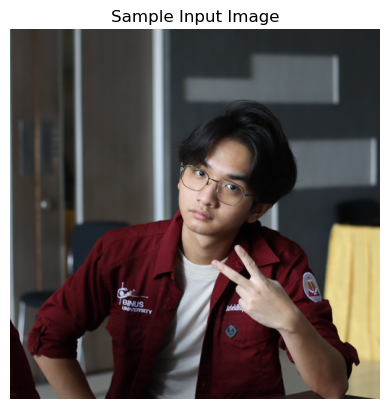

Preprocessed image tensor shape for VAE: torch.Size([1, 3, 512, 512])


In [8]:
def load_image(image_path, size=(WIDTH, HEIGHT)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(size)
    return img

def preprocess_image_for_vae(image_pil, device=DEVICE):
    image_np = np.array(image_pil).astype(np.float32) / 255.0 # Normalize to [0, 1]
    image_tensor = torch.from_numpy(image_np).permute(2, 0, 1) # HWC to CHW
    image_tensor = rescale(image_tensor, (0, 1), (-1, 1)) # Rescale to [-1, 1]
    return image_tensor.unsqueeze(0).to(device) # Add batch dim and move to device

# IMPORTANT: Replace with a path to your own image file
SAMPLE_IMAGE_PATH = "../images/ariel_crop.jpg" # Example path, create or replace this

try:
    sample_pil_image = load_image(SAMPLE_IMAGE_PATH)
    input_image_tensor_vae = preprocess_image_for_vae(sample_pil_image)
    
    plt.imshow(sample_pil_image)
    plt.title("Sample Input Image")
    plt.axis('off')
    plt.show()
    print(f"Preprocessed image tensor shape for VAE: {input_image_tensor_vae.shape}") # (1, 3, HEIGHT, WIDTH)
except FileNotFoundError:
    print(f"Sample image not found at '{SAMPLE_IMAGE_PATH}'. Please provide a valid image path.")
    input_image_tensor_vae = None
except Exception as e:
    print(f"Error loading or preprocessing image: {e}")
    input_image_tensor_vae = None

#### B.2 VAE Encoder: Image to Latent Space

The encoder compresses the image. We'll visualize some intermediate feature maps and the final latent representation.

Type of models['encoder']: <class 'encoder.VAE_Encoder'>
Structure of models['encoder'] (listing all direct children modules):
 Layer 0: Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 Layer 1: VAE_ResidualBlock(
  (groupnorm_1): GroupNorm(32, 128, eps=1e-05, affine=True)
  (conv_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (groupnorm_2): GroupNorm(32, 128, eps=1e-05, affine=True)
  (conv_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (residual_layer): Identity()
)
 Layer 2: VAE_ResidualBlock(
  (groupnorm_1): GroupNorm(32, 128, eps=1e-05, affine=True)
  (conv_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (groupnorm_2): GroupNorm(32, 128, eps=1e-05, affine=True)
  (conv_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (residual_layer): Identity()
)
 Layer 3: Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
 Layer 4: VAE_ResidualBlock(
  (groupnorm_1): Group

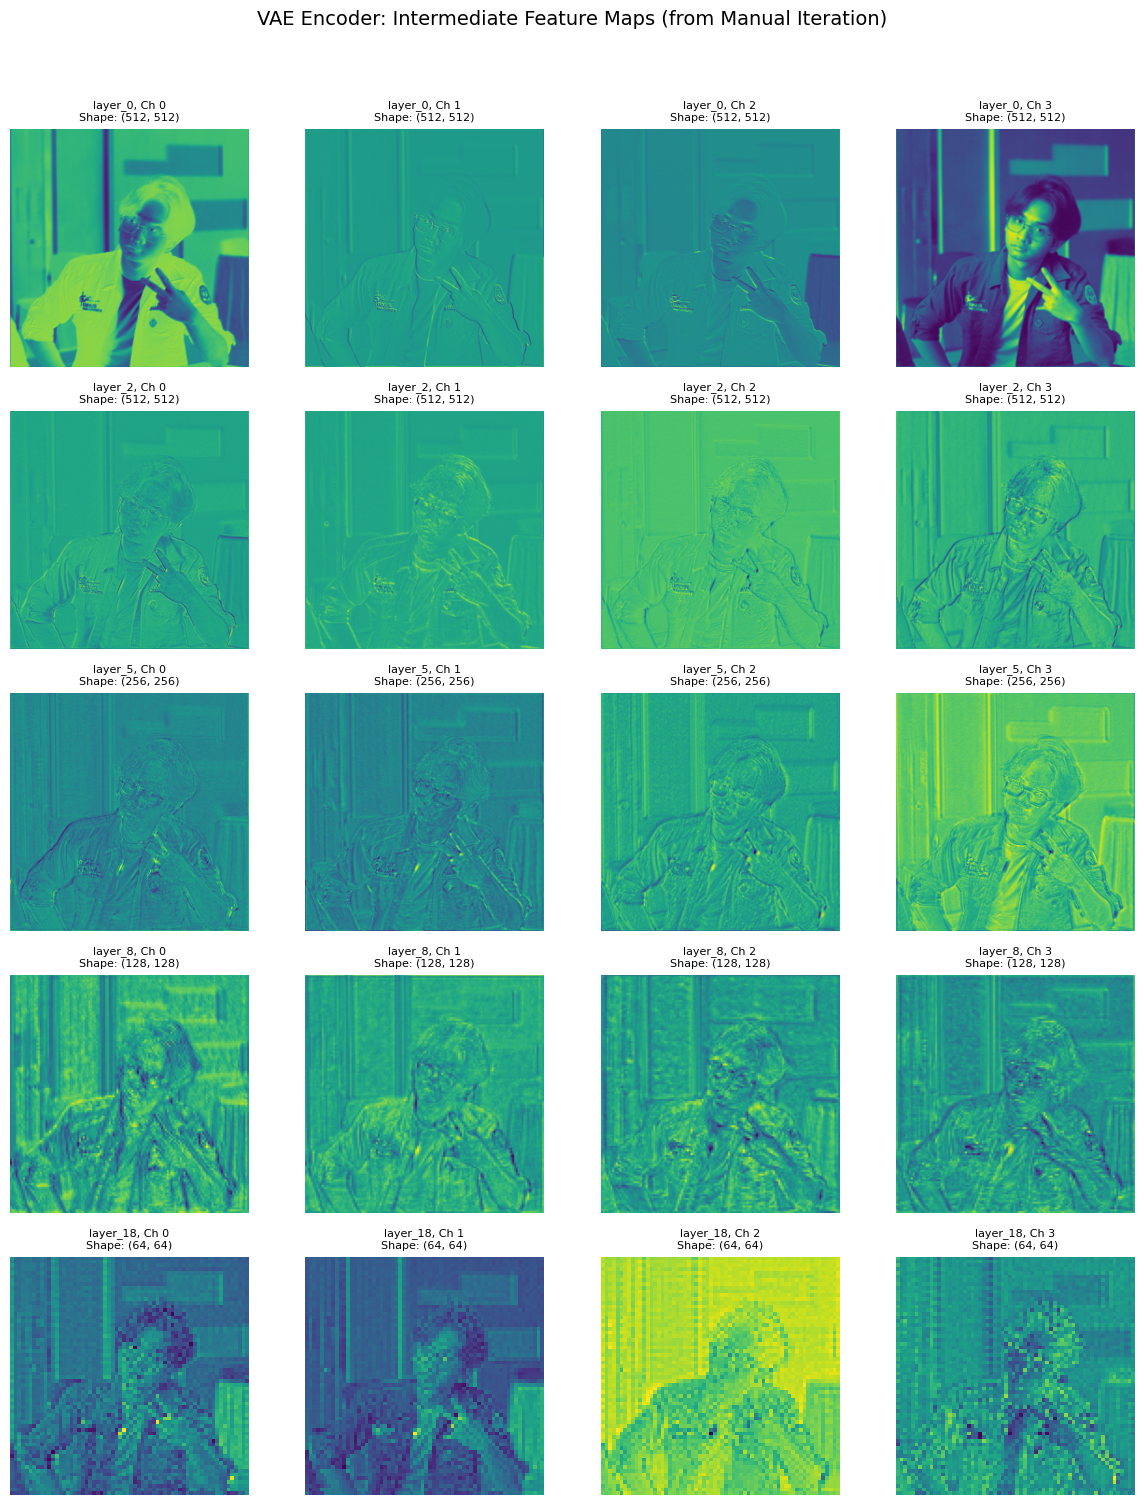


Plotting the 4-channel latents obtained from VAE_Encoder.forward(). These will be used downstream.


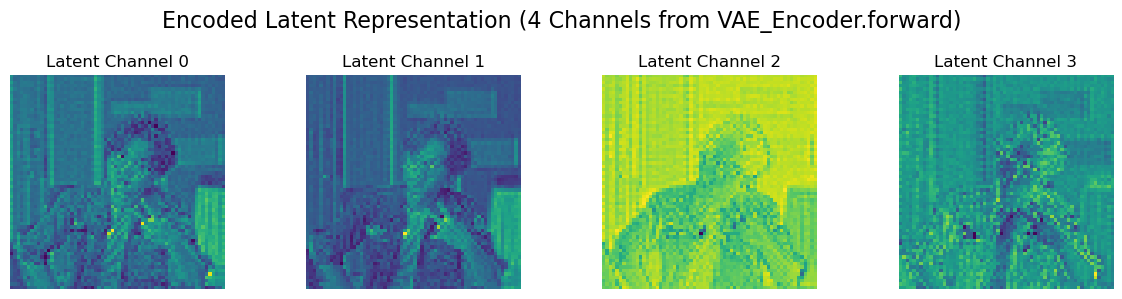

In [9]:
if models and input_image_tensor_vae is not None:
    vae_encoder_instance = models['encoder'] # This is an instance of VAE_Encoder

    print(f"Type of models['encoder']: {type(vae_encoder_instance)}")
    print("Structure of models['encoder'] (listing all direct children modules):")
    encoder_children = list(vae_encoder_instance.children())
    for i, module_obj in enumerate(encoder_children):
        print(f" Layer {i}: {module_obj}")
    print(f"Total number of direct modules in models['encoder']: {len(encoder_children)}")

    # Noise for the reparameterization trick (should be 4 channels for the VAE_Encoder.forward method)
    reparam_noise_for_forward_method = torch.randn((1, 4, LATENTS_HEIGHT, LATENTS_WIDTH), device=DEVICE)

    scaled_latents_from_forward = None # Initialize
    mean_from_forward = None
    log_variance_from_forward = None

    try:
        with torch.no_grad():
            # ---Call the VAE_Encoder's own forward method.---
            scaled_latents_from_forward = vae_encoder_instance(input_image_tensor_vae, reparam_noise_for_forward_method)
        
        print(f"\nShape of scaled_latents (from VAE_Encoder.forward()): {scaled_latents_from_forward.shape}")
        
        if scaled_latents_from_forward.shape[1] != 4:
            print("ERROR: VAE_Encoder.forward() did not produce 4-channel latents as expected.")
            print("This indicates a fundamental issue with the VAE_Encoder class definition in 'encoder.py' or how it's being used/loaded.")
            scaled_latents_for_downstream = None # Critical error, do not proceed with these latents
        else:
            print("VAE_Encoder.forward() call successful, produced 4-channel latents.")
            scaled_latents_for_downstream = scaled_latents_from_forward # Use these for subsequent cells

    except Exception as e:
        print(f"ERROR calling vae_encoder_instance.forward(): {e}")
        print("This suggests a mismatch between the VAE_Encoder class definition and the loaded weights/model state, or an issue within the VAE_Encoder.forward method itself.")
        scaled_latents_for_downstream = None


    # --- Manual iteration for INSPECTION of intermediate layers ---
    print("\n--- Inspecting manual iteration for visualization of intermediate layers ---")
    temp_x_viz = input_image_tensor_vae
    intermediate_outputs_encoder_viz = {} 
    
    num_actual_modules = len(encoder_children)
    # Define which layers to visualize based on the printed structure if needed
    layer_indices_to_viz_encoder = sorted(list(set({0, min(2, num_actual_modules-1), 
                                               min(5, num_actual_modules-1), 
                                               min(8, num_actual_modules-1),
                                               max(0, num_actual_modules - 1)}))) # Visualize first, some middle, and last

    for i, module in enumerate(encoder_children): # Iterate over actual children of the instance
        # Asymmetric padding logic from VAE_Encoder.forward()
        # This padding is applied *before* a strided convolution.
        if getattr(module, 'stride', None) == (2, 2):
             # Pad: (Padding_Left, Padding_Right, Padding_Top, Padding_Bottom).
            temp_x_viz = F.pad(temp_x_viz, (0, 1, 0, 1))
        
        temp_x_viz = module(temp_x_viz) # Apply the module
        
        if i in layer_indices_to_viz_encoder:
            intermediate_outputs_encoder_viz[f'layer_{i}'] = temp_x_viz.cpu().detach()
            print(f"Shape after manual iter layer {i} ({type(module).__name__}): {temp_x_viz.shape}")
    
    output_of_manual_iteration = temp_x_viz # This is the 512-channel tensor you observed
    print(f"Final shape of output_of_manual_iteration (prenoise_latents in previous attempt): {output_of_manual_iteration.shape}")
    
    # If you wanted to manually do the reparameterization from this 512-channel output
    if output_of_manual_iteration.shape[1] == 8: # Check if it's 8 channels as expected by VAE_Encoder.forward before chunk
        print("Manual iteration ended with 8 channels. Chunking for debug:")
        debug_mean, debug_log_variance = torch.chunk(output_of_manual_iteration, 2, dim=1)
        print(f"  Debug mean shape: {debug_mean.shape}, Debug log_var shape: {debug_log_variance.shape}")
        # This would then allow the reparameterization with 4-channel noise to work.
        # The discrepancy is why models['encoder'] instance's children don't go down to 8.
    elif output_of_manual_iteration.shape[1] == 512:
         print("Manual iteration ended with 512 channels, as observed. This means models['encoder'] instance's children don't include the final 512->8 reduction layers.")


    # Visualization of intermediate_outputs_encoder_viz (if populated)
    if intermediate_outputs_encoder_viz:
        print("\nPlotting intermediate feature maps from manual iteration...")
        # Determine number of rows/cols for subplot
        num_viz_layers = len(intermediate_outputs_encoder_viz)
        # For each layer, show up to 4 channels
        total_plots_possible = 0
        for _, out_tensor in intermediate_outputs_encoder_viz.items():
            total_plots_possible += min(4, out_tensor.shape[1])
        
        cols_viz = 4 # Max 4 channels per layer shown side-by-side
        rows_viz = 0
        # Calculate rows needed based on how many layers we are visualizing and how many channels per layer
        temp_plot_count = 0
        temp_row_count = 0
        current_row_plots = 0
        for name, out_tensor in intermediate_outputs_encoder_viz.items():
            num_ch_to_show = min(cols_viz, out_tensor.shape[1])
            if current_row_plots + num_ch_to_show > cols_viz:
                temp_row_count +=1
                current_row_plots = 0
            current_row_plots += num_ch_to_show
        if current_row_plots > 0: # account for the last row
            temp_row_count +=1
        rows_viz = temp_row_count

        if rows_viz > 0 :
            plt.figure(figsize=(cols_viz * 3, rows_viz * 3)) # Adjusted figsize
            plot_idx = 1
            for name, out_tensor in intermediate_outputs_encoder_viz.items():
                num_channels_to_show = min(cols_viz, out_tensor.shape[1])
                for i_ch in range(num_channels_to_show):
                    plt.subplot(rows_viz, cols_viz, plot_idx)
                    plt.imshow(out_tensor[0, i_ch], cmap='viridis')
                    plt.title(f"{name}, Ch {i_ch}\nShape: {tuple(out_tensor.shape[2:])}", fontsize=8)
                    plt.axis('off')
                    plot_idx +=1
            plt.tight_layout(rect=[0,0,1,0.95])
            plt.suptitle("VAE Encoder: Intermediate Feature Maps (from Manual Iteration)", fontsize=14, y=1.0)
            plt.show()

    # Proceed with visualization of the 4-channel scaled_latents_from_forward if successfully obtained
    if scaled_latents_for_downstream is not None and scaled_latents_for_downstream.shape[1] == 4:
        print("\nPlotting the 4-channel latents obtained from VAE_Encoder.forward(). These will be used downstream.")
        plt.figure(figsize=(12, 3))
        for i_ch in range(4):
            plt.subplot(1, 4, i_ch + 1)
            plt.imshow(scaled_latents_for_downstream[0, i_ch].cpu().detach().numpy(), cmap='viridis')
            plt.title(f"Latent Channel {i_ch}")
            plt.axis('off')
        plt.suptitle("Encoded Latent Representation (4 Channels from VAE_Encoder.forward)", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
    elif scaled_latents_from_forward is not None: # If it was obtained but had wrong shape
        print(f"Skipping final latent visualization as scaled_latents_from_forward has shape {scaled_latents_from_forward.shape} instead of 4 channels.")
    else: # If it was None due to an error
        print("Skipping final latent visualization as scaled_latents_from_forward was not successfully computed.")

else:
    print("Models or sample image not loaded, skipping VAE encoder analysis.")
    scaled_latents_for_downstream = None 

Call the VAE_Encoder's own forward method.

This method internally handles iterating through its layers,producing 8 channels, chunking to mean/log_var (4 channels each),reparameterizing, and scaling.We need to get mean and log_var from it if we want to inspect them,or we can just get the final scaled_latents.The VAE_Encoder.forward() already returns the scaled, sampled latents.

Manual iteration for INSPECTION of intermediate layers

This part is for visualizing what happens layer-by-layer if we manually iterate.The output of this manual iteration might differ from the VAE_Encoder.forward() ifmodels['encoder'] instance doesn't fully represent all layers defined in VAE_Encoder class's __init__(e.g., if model_converter didn't map weights for the final channel-reducing layers).

#### B.3 VAE Decoder: Latent Space to Image

The decoder reconstructs the image from the latent representation.

Reconstructed image tensor shape: torch.Size([1, 3, 512, 512])


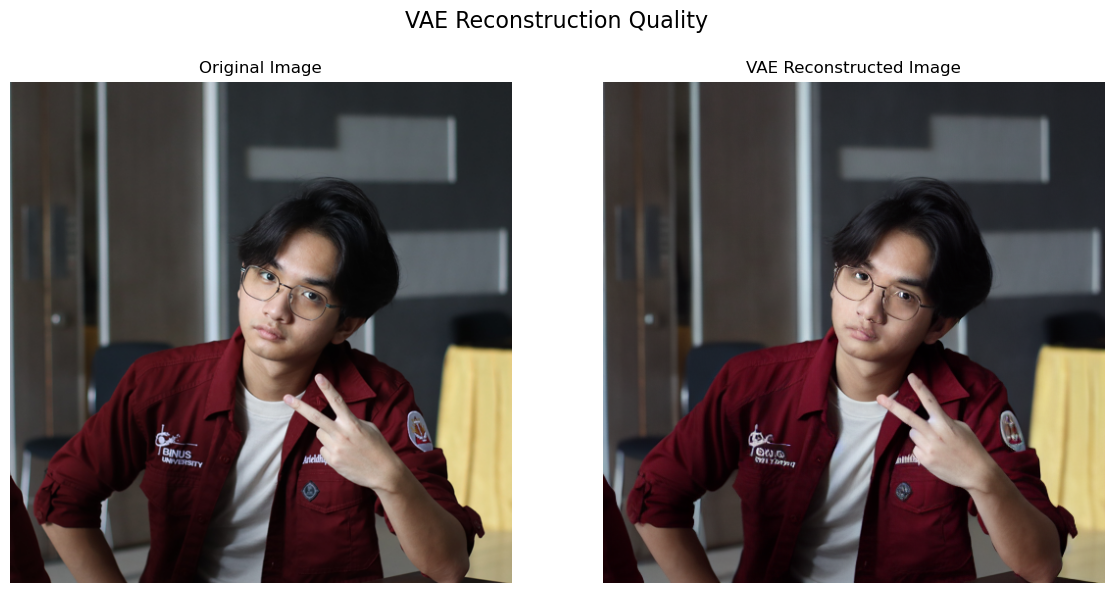

In [10]:
# Ensure 'scaled_latents_for_downstream' is available from the previous cell (B.2)
# It should be the 4-channel output from vae_encoder_instance.forward()

if models and 'scaled_latents_for_downstream' in locals() and scaled_latents_for_downstream is not None:
    vae_decoder = models['decoder']

    with torch.no_grad():
        # Use the correctly processed latents from the VAE Encoder's forward method
        reconstructed_image_tensor = vae_decoder(scaled_latents_for_downstream) 
    
    print(f"Reconstructed image tensor shape: {reconstructed_image_tensor.shape}") # Expected: (1, 3, HEIGHT, WIDTH)

    # Postprocess for visualization
    # Ensure tensor is on CPU for numpy conversion if it's not already
    reconstructed_image_viz = rescale(reconstructed_image_tensor.cpu().squeeze(0), (-1, 1), (0, 1), clamp=True)
    reconstructed_image_viz = reconstructed_image_viz.permute(1, 2, 0).numpy()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    if 'sample_pil_image' in locals() and sample_pil_image is not None:
        plt.imshow(sample_pil_image)
        plt.title("Original Image")
    else:
        plt.text(0.5, 0.5, 'Original Image Not Loaded', ha='center', va='center')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_image_viz)
    plt.title("VAE Reconstructed Image")
    plt.axis('off')
    
    plt.suptitle("VAE Reconstruction Quality", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
else:
    print("Models or 'scaled_latents_for_downstream' not available, skipping VAE decoder analysis.")
    if 'models' not in locals():
        print("Reason: 'models' dictionary not found.")
    if 'scaled_latents_for_downstream' not in locals():
        print("Reason: 'scaled_latents_for_downstream' not found (was it computed in the VAE Encoder cell?).")
    elif scaled_latents_for_downstream is None:
        print("Reason: 'scaled_latents_for_downstream' is None (VAE Encoder cell might have failed).")

### C. Diffusion Process Components

#### C.1 Noise Schedule (`DDPMSampler`)

The `DDPMSampler` defines how noise is added (forward process) and removed (reverse process).

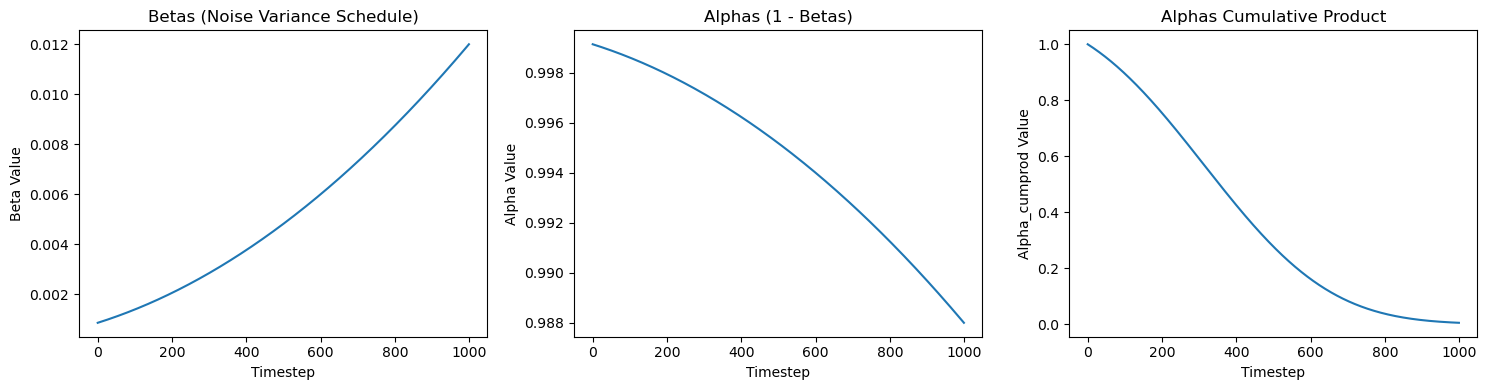

In [11]:
generator_for_sampler = torch.Generator(device=DEVICE)
generator_for_sampler.manual_seed(42) # For reproducibility
sampler_ddpm = DDPMSampler(generator=generator_for_sampler) # Uses default num_training_steps=1000

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(sampler_ddpm.betas.cpu().numpy())
plt.title("Betas (Noise Variance Schedule)")
plt.xlabel("Timestep")
plt.ylabel("Beta Value")

plt.subplot(1, 3, 2)
plt.plot(sampler_ddpm.alphas.cpu().numpy())
plt.title("Alphas (1 - Betas)")
plt.xlabel("Timestep")
plt.ylabel("Alpha Value")

plt.subplot(1, 3, 3)
plt.plot(sampler_ddpm.alphas_cumprod.cpu().numpy())
plt.title("Alphas Cumulative Product")
plt.xlabel("Timestep")
plt.ylabel("Alpha_cumprod Value")

plt.tight_layout()
plt.show()

This set of plots visualizes the noise schedule used in the Denoising Diffusion Probabilistic Model (DDPM). 

The first plot, "Betas," shows the variance of noise added at each timestep; it starts small and increases, meaning more noise is added at later timesteps in the forward (noising) process.

 The "Alphas" plot (where alpha = 1 - beta) correspondingly shows a decreasing value, representing the signal preservation rate. 
 
 Finally, "Alphas Cumulative Product" shows the cumulative product of alphas, which indicates the overall signal rate remaining from the original image after a certain number of noising steps; this value rapidly decreases, illustrating how quickly the original image information is obscured by noise as timesteps increase.

#### C.2 Forward Diffusion (Noising Process)

Let's visualize how an image (represented by its VAE latents) becomes noisy over timesteps.

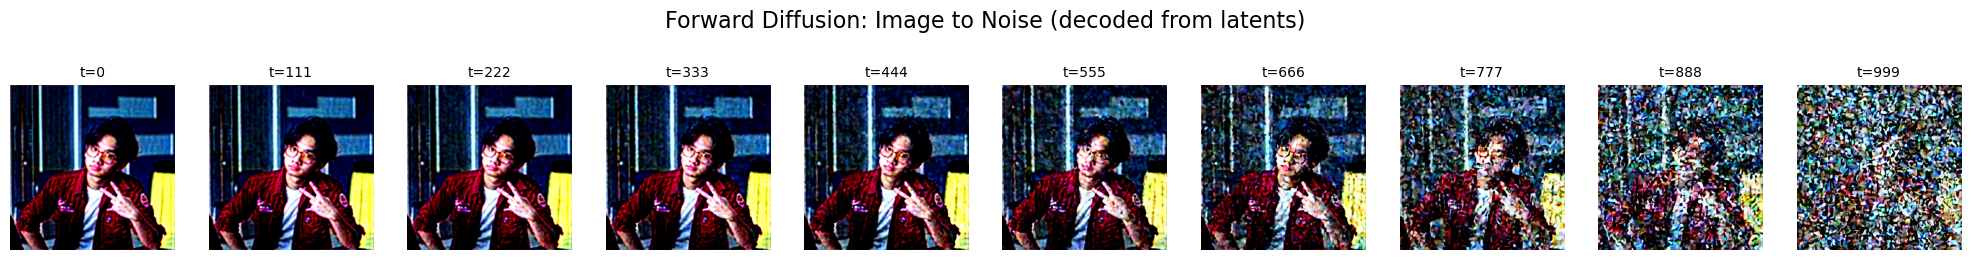

In [12]:
if models and 'scaled_latents_for_downstream' in locals() and scaled_latents_for_downstream is not None:
    num_noising_steps_to_show = 10
    # Pick timesteps spread across the 0-999 range
    # Ensure sampler_ddpm is defined (from cell C.1)
    if 'sampler_ddpm' not in locals():
        print("ERROR: 'sampler_ddpm' is not defined. Please run cell C.1 first.")
    else:
        noising_timesteps = torch.linspace(0, sampler_ddpm.num_train_timesteps - 1, num_noising_steps_to_show, dtype=torch.long).to(DEVICE)

        noisy_latents_sequence = []
        for t_val in noising_timesteps:
            # Ensure t_val is a tensor for indexing alphas_cumprod in add_noise
            current_timestep_tensor = torch.tensor([t_val], device=DEVICE, dtype=torch.long)
            # Use the correctly processed latents
            noisy_latent = sampler_ddpm.add_noise(scaled_latents_for_downstream, current_timestep_tensor) 
            noisy_latents_sequence.append(noisy_latent)

        # Decode these noisy latents back to image space for visualization
        plt.figure(figsize=(2 * num_noising_steps_to_show, 2.5)) # Increased height slightly for titles
        vae_decoder = models['decoder']
        for i, noisy_latent_step in enumerate(noisy_latents_sequence):
            with torch.no_grad():
                decoded_noisy_image = vae_decoder(noisy_latent_step)
            
            # Ensure tensor is on CPU for numpy conversion
            img_viz = rescale(decoded_noisy_image.cpu().squeeze(0), (-1, 1), (0, 1), clamp=True)
            img_viz = img_viz.permute(1, 2, 0).numpy()
            
            plt.subplot(1, num_noising_steps_to_show, i + 1)
            plt.imshow(img_viz)
            plt.title(f"t={noising_timesteps[i].item()}", fontsize=10)
            plt.axis('off')
        plt.suptitle("Forward Diffusion: Image to Noise (decoded from latents)", y=1.02, fontsize=16) # Adjusted y for suptitle
        plt.tight_layout(rect=[0, 0, 1, 0.93]) # Adjusted rect for suptitle
        plt.show()
else:
    print("Models or 'scaled_latents_for_downstream' not available, skipping forward diffusion visualization.")
    if 'models' not in locals():
        print("Reason: 'models' dictionary not found.")
    if 'scaled_latents_for_downstream' not in locals():
        print("Reason: 'scaled_latents_for_downstream' not found (was it computed in the VAE Encoder cell?).")
    elif 'scaled_latents_for_downstream' in locals() and scaled_latents_for_downstream is None:
        print("Reason: 'scaled_latents_for_downstream' is None (VAE Encoder cell might have failed).")

#### C.3 Time Embedding

The U-Net needs to know the current timestep `t`. This is provided via a time embedding.

Raw sinusoidal time embedding shape for t=500: torch.Size([1, 320])
Processed time embedding shape: torch.Size([1, 1280])


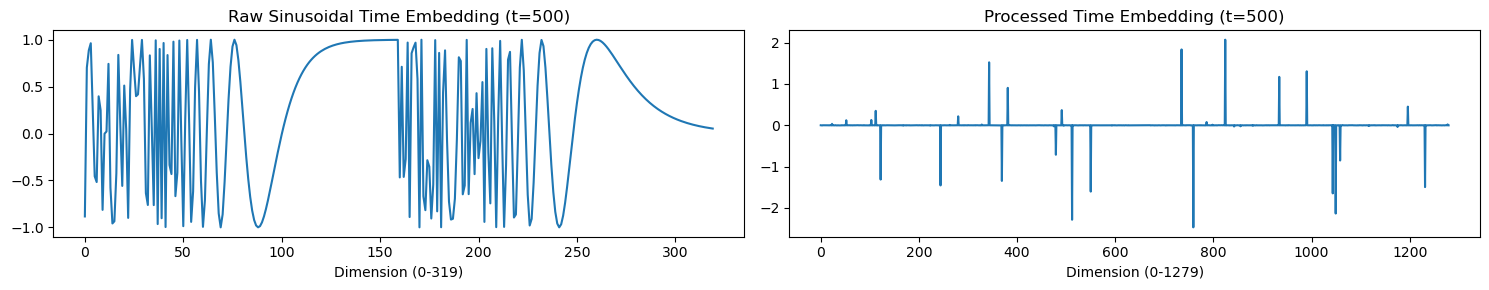

In [13]:
sample_timestep_val = 500 # Example timestep

# Raw sinusoidal embedding (from pipeline.py's get_time_embedding)
raw_time_emb = get_time_embedding(sample_timestep_val)
print(f"Raw sinusoidal time embedding shape for t={sample_timestep_val}: {raw_time_emb.shape}") # (1, 320)

if models:
    # Processed by the Diffusion model's TimeEmbedding module
    diffusion_model_time_embed_layer = models['diffusion'].time_embedding
    processed_time_emb = diffusion_model_time_embed_layer(raw_time_emb.to(DEVICE))
    print(f"Processed time embedding shape: {processed_time_emb.shape}") # (1, 1280)

    plt.figure(figsize=(15, 3))
    plt.subplot(1, 2, 1)
    plt.plot(raw_time_emb.squeeze().cpu().numpy())
    plt.title(f"Raw Sinusoidal Time Embedding (t={sample_timestep_val})")
    plt.xlabel("Dimension (0-319)")

    plt.subplot(1, 2, 2)
    plt.plot(processed_time_emb.squeeze().cpu().detach().numpy())
    plt.title(f"Processed Time Embedding (t={sample_timestep_val})")
    plt.xlabel("Dimension (0-1279)")
    plt.tight_layout()
    plt.show()
else:
    print("Models not loaded, skipping processed time embedding visualization.")

The plots illustrate how the diffusion model represents a specific timestep (t=500) as a numerical embedding. 

The "Raw Sinusoidal Time Embedding" on the left shows the initial, fixed representation using sine and cosine functions of varying frequencies, a common technique from transformers to encode positional or sequential information. 

The "Processed Time Embedding" on the right shows this raw embedding after it has been passed through a small neural network (the TimeEmbedding module). This processing transforms the fixed sinusoidal pattern into a more abstract, learnable representation (expanded from 320 to 1280 dimensions) that the main U-Net model can more effectively use to understand the current noise level and guide the denoising process.

#### C.4 The U-Net (Noise Predictor)

The U-Net (`Diffusion` class in `diffusion.py`) predicts the noise in the latents given the noisy latents, the timestep embedding, and the text context.

Due to its complexity, we'll focus on its inputs and outputs, and briefly mention its key internal blocks (`UNET_ResidualBlock`, `UNET_AttentionBlock`).

Attempting to free up GPU memory...
CUDA cache cleared.
Sample noisy latents shape for U-Net: torch.Size([1, 4, 64, 64]), Device: cuda:0
Sample context shape for U-Net: torch.Size([1, 77, 768]), Device: cuda:0
Sample raw time embedding shape for U-Net: torch.Size([1, 320]), Device: cuda:0
Predicted noise shape from U-Net: torch.Size([1, 4, 64, 64])


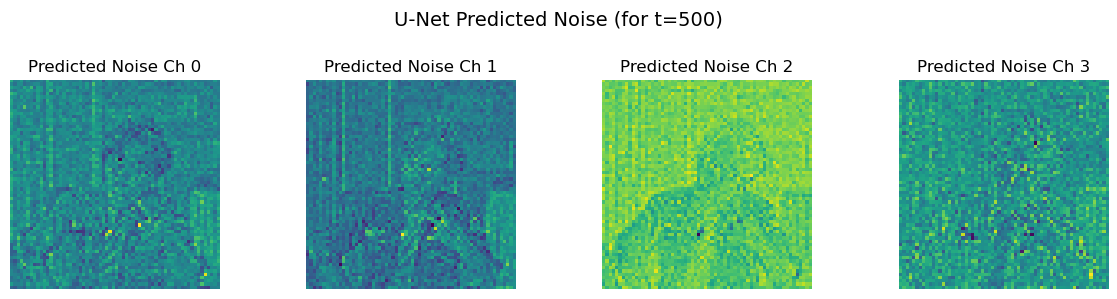


Key U-Net Blocks:
- UNET_ResidualBlock: Combines image features with time embeddings.
- UNET_AttentionBlock: Incorporates text context via CrossAttention and refines features with SelfAttention.


In [14]:
if 'sample_timestep_val' not in locals():
    sample_timestep_val = 500 # Default if not run after C.3

if (models and 
    'scaled_latents_for_downstream' in locals() and scaled_latents_for_downstream is not None and
    'cond_context' in locals() and cond_context is not None and
    'sampler_ddpm' in locals() 
   ):

    # 0. Clean up memory before running the U-Net
    print("Attempting to free up GPU memory...")
    if 'clip_model' in locals() and isinstance(clip_model, torch.nn.Module):
        clip_model.to(IDLE_DEVICE if IDLE_DEVICE else DEVICE) # Move to IDLE or keep on DEVICE if no IDLE
    if 'vae_encoder_instance' in locals() and isinstance(vae_encoder_instance, torch.nn.Module):
        vae_encoder_instance.to(IDLE_DEVICE if IDLE_DEVICE else DEVICE)
    if 'vae_decoder' in locals() and isinstance(vae_decoder, torch.nn.Module): # Check if vae_decoder was used and defined
        vae_decoder.to(IDLE_DEVICE if IDLE_DEVICE else DEVICE)

    if DEVICE == "cuda":
        torch.cuda.empty_cache()
        print("CUDA cache cleared.")

    unet_model = models['diffusion'] # This is the nn.Module named 'Diffusion' which contains the U-Net
    unet_model.to(DEVICE) # Ensure U-Net is on the correct (active) device
    
    # Prepare sample inputs for the U-Net
    # 1. Noisy latents (e.g., from forward diffusion at a specific timestep)
    example_timestep_for_unet = torch.tensor([sample_timestep_val], device=DEVICE, dtype=torch.long)
    
    if 'noisy_latents_sequence' in locals() and noisy_latents_sequence and len(noisy_latents_sequence) > 0 :
        idx_to_use = len(noisy_latents_sequence) // 2
        if idx_to_use < len(noisy_latents_sequence):
            sample_noisy_latents = noisy_latents_sequence[idx_to_use].to(DEVICE) # Ensure it's on DEVICE
        else: 
            print("Warning: noisy_latents_sequence was unexpectedly empty or too short. Generating new noisy latents.")
            sample_noisy_latents = sampler_ddpm.add_noise(scaled_latents_for_downstream.to(DEVICE), example_timestep_for_unet)
    else:
        print("Info: 'noisy_latents_sequence' not found or empty. Generating new noisy latents for U-Net input.")
        sample_noisy_latents = sampler_ddpm.add_noise(scaled_latents_for_downstream.to(DEVICE), example_timestep_for_unet)
    
    print(f"Sample noisy latents shape for U-Net: {sample_noisy_latents.shape}, Device: {sample_noisy_latents.device}")

    # 2. Text context (from CLIP - cell A.4)
    sample_context_for_unet = cond_context.to(DEVICE) # Ensure it's on DEVICE
    print(f"Sample context shape for U-Net: {sample_context_for_unet.shape}, Device: {sample_context_for_unet.device}")

    # 3. Time embedding (raw timestep value, will be processed internally by unet_model.time_embedding)
    sample_raw_time_for_unet = get_time_embedding(sample_timestep_val).to(DEVICE)
    print(f"Sample raw time embedding shape for U-Net: {sample_raw_time_for_unet.shape}, Device: {sample_raw_time_for_unet.device}")
    
    predicted_noise = None # Initialize
    try:
        # Pass through the U-Net
        with torch.no_grad():
            predicted_noise = unet_model(sample_noisy_latents, sample_context_for_unet, sample_raw_time_for_unet)
        
        print(f"Predicted noise shape from U-Net: {predicted_noise.shape}") 

        # Visualize some channels of the predicted noise
        plt.figure(figsize=(12, 3))
        for i in range(min(4, predicted_noise.shape[1])): 
            plt.subplot(1, min(4, predicted_noise.shape[1]), i + 1)
            plt.imshow(predicted_noise[0, i].cpu().numpy(), cmap='viridis')
            plt.title(f"Predicted Noise Ch {i}")
            plt.axis('off')
        plt.suptitle(f"U-Net Predicted Noise (for t={sample_timestep_val})", fontsize=14) 
        plt.tight_layout(rect=[0,0,1,0.93]) 
        plt.show()

        print("\nKey U-Net Blocks:")
        print("- UNET_ResidualBlock: Combines image features with time embeddings.")
        print("- UNET_AttentionBlock: Incorporates text context via CrossAttention and refines features with SelfAttention.")
    finally:
        # Move U-Net back to idle device after use if applicable
        if unet_model is not None and isinstance(unet_model, torch.nn.Module):
             unet_model.to(IDLE_DEVICE if IDLE_DEVICE else DEVICE)
        if DEVICE == "cuda":
            torch.cuda.empty_cache() # Clean cache again after the operation


else:
    print("Models, latents, context, or sampler not available. Skipping U-Net analysis.")
    if 'models' not in locals() or models is None: print("Reason: 'models' not loaded.")
    if 'scaled_latents_for_downstream' not in locals() or scaled_latents_for_downstream is None: print("Reason: 'scaled_latents_for_downstream' not available (from cell B.2).")
    if 'cond_context' not in locals() or cond_context is None: print("Reason: 'cond_context' not available (from cell A.4).")
    if 'sampler_ddpm' not in locals() or sampler_ddpm is None: print("Reason: 'sampler_ddpm' not available (from cell C.1).")

Visualizing denoising effect for t=500


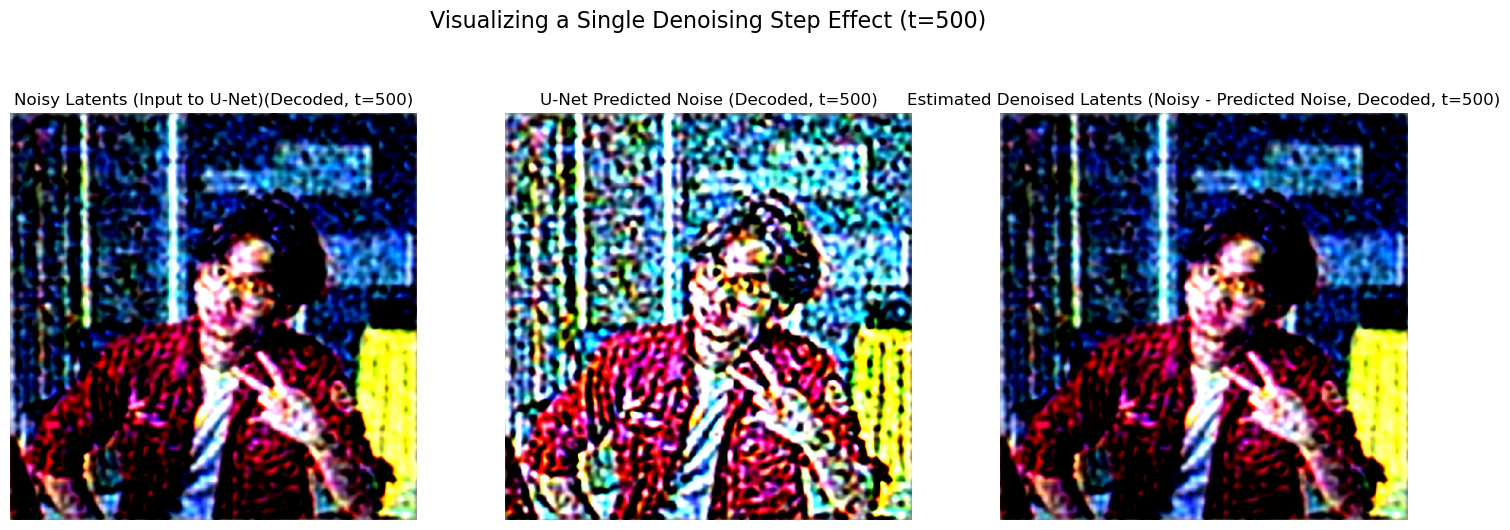

In [17]:

# This cell uses variables from cell C.4: 
# - sample_noisy_latents
# - predicted_noise
# - sample_timestep_val (for titles)
# - models (for vae_decoder)
# - DEVICE, IDLE_DEVICE

if (models and 
    'sample_noisy_latents' in locals() and sample_noisy_latents is not None and
    'predicted_noise' in locals() and predicted_noise is not None and
    'vae_decoder' in locals() # Ensure vae_decoder was defined (e.g. from models['decoder'])
   ):

    print(f'Visualizing denoising effect for t={sample_timestep_val}')
    
    # Ensure VAE decoder is on the correct device for this operation
    vae_decoder_model = models['decoder']
    vae_decoder_model.to(DEVICE)

    # 1. Decode the noisy latents (input to U-Net)
    with torch.no_grad():
        decoded_noisy_input = vae_decoder_model(sample_noisy_latents.to(DEVICE))
    img_noisy_input_viz = rescale(decoded_noisy_input.cpu().squeeze(0), (-1, 1), (0, 1), clamp=True)
    img_noisy_input_viz = img_noisy_input_viz.permute(1, 2, 0).numpy()

    # 2. Decode the predicted noise (output from U-Net)
    # This shows what the noise pattern looks like in image space. It can be abstract.
    with torch.no_grad():
        decoded_predicted_noise = vae_decoder_model(predicted_noise.to(DEVICE))
    img_predicted_noise_viz = rescale(decoded_predicted_noise.cpu().squeeze(0), (-1, 1), (0, 1), clamp=True)
    img_predicted_noise_viz = img_predicted_noise_viz.permute(1, 2, 0).numpy()

    # 3. Estimate denoised latents by simple subtraction and decode
    # Note: This is a simplification. The actual sampler.step() is more complex.
    estimated_denoised_latents = sample_noisy_latents.to(DEVICE) - predicted_noise.to(DEVICE)
    with torch.no_grad():
        decoded_estimated_denoised = vae_decoder_model(estimated_denoised_latents)
    img_estimated_denoised_viz = rescale(decoded_estimated_denoised.cpu().squeeze(0), (-1, 1), (0, 1), clamp=True)
    img_estimated_denoised_viz = img_estimated_denoised_viz.permute(1, 2, 0).numpy()
    
    # Move VAE decoder back to idle if needed
    if IDLE_DEVICE:
        vae_decoder_model.to(IDLE_DEVICE)

    # Plotting
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img_noisy_input_viz)
    plt.title(f"Noisy Latents (Input to U-Net)(Decoded, t={sample_timestep_val})")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(img_predicted_noise_viz)
    plt.title(f"U-Net Predicted Noise (Decoded, t={sample_timestep_val})")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(img_estimated_denoised_viz)
    plt.title(f"Estimated Denoised Latents (Noisy - Predicted Noise, Decoded, t={sample_timestep_val})")
    plt.axis('off')

    plt.suptitle(f"Visualizing a Single Denoising Step Effect (t={sample_timestep_val})", fontsize=16, y=1.05)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

else:
    print("debug again")

This is a visualization of one small step in the image generation process. 

The first image, "Noisy Latents," is what the AI sees at a particular moment, it's a very noisy, abstract version of what will eventually become the final image. 

The second image, "U-Net Predicted Noise," is the AI's attempt to identify just the noise pattern in that first image. 

The third image, "Estimated Denoised Latents," shows what happens if you simply subtract that predicted noise from the noisy input. 

Ideally, this makes the image slightly clearer and closer to the final desired output. It shows not much diffrent in timestep 500 meaning the amount of noise removed in one step is subtle, or the VAE decoding of these abstract latents doesn't perfectly show the fine changes. The full generation involves many such steps, gradually refining the image.

## III. The Full Generation Pipeline (Reverse Diffusion)

Now, let's use the `generate` function from `pipeline.py` to see the entire process in action, from a prompt & image to an image.

In [2]:
# --- Configuration ---
DEVICE = "cpu"
ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.backends.mps.is_available() or torch.backends.mps.is_built()) and ALLOW_MPS: # Updated MPS check
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

# Adjust paths to your data files
TOKENIZER_VOCAB_PATH = "../data/vocab.json"
TOKENIZER_MERGES_PATH = "../data/merges.txt"
MODEL_FILE_PATH = "../data/v1-5-pruned-emaonly.ckpt"
INPUT_IMAGE_PATH = "../images/ariel.jpg" # Example for image-to-image

# --- Helper to manage model devices ---
def manage_device(model, target_device, current_idle_device):
    if model is not None and isinstance(model, torch.nn.Module):
        model.to(target_device)
    # Return the device the model was on before moving to target_device,
    # or the current_idle_device if it was already there.
    # This part is tricky if we want to perfectly mimic to_idle.
    # For simplicity in this script, we'll just move models as needed.

Using device: cuda


### Modified `generate` function for Visualization

We'll copy the generate function here and add a hook to store latents at different steps.

In [3]:
# --- Modified Generate Function with Visualization Hooks ---
def generate_and_visualize_steps(
    prompt,
    uncond_prompt=None,
    input_image_pil=None, # Expects a PIL image now
    strength=0.8,
    do_cfg=True,
    cfg_scale=7.5,
    sampler_name="ddpm",
    n_inference_steps=50,
    models={},
    seed=None,
    device=None,
    idle_device=None, 
    tokenizer=None,
    store_every_n_steps_viz=5
):
    intermediate_decoded_images_viz = []
    timesteps_labels_viz = []

    # Get model references
    clip = models["clip"]
    diffusion_unet = models["diffusion"]
    vae_decoder = models["decoder"]
    vae_encoder = models.get("encoder") # Optional, for img2img

    # Define to_idle helper
    _to_idle = lambda m: m.to(idle_device) if idle_device and m is not None else m

    with torch.no_grad():
        if not 0 < strength <= 1:
            raise ValueError("strength must be between 0 and 1 for img2img")

        generator = torch.Generator(device=device)
        if seed is None:
            generator.seed()
        else:
            generator.manual_seed(seed)

        # 1. CLIP Processing
        clip.to(device)
        if do_cfg:
            cond_tokens_data = tokenizer.batch_encode_plus([prompt], padding="max_length", max_length=77, truncation=True, return_tensors="pt")
            cond_tokens = cond_tokens_data.input_ids.to(device)
            cond_context = clip(cond_tokens)
            
            uncond_tokens_data = tokenizer.batch_encode_plus([uncond_prompt], padding="max_length", max_length=77, truncation=True, return_tensors="pt")
            uncond_tokens = uncond_tokens_data.input_ids.to(device)
            uncond_context = clip(uncond_tokens)
            context = torch.cat([cond_context, uncond_context])
        else:
            tokens_data = tokenizer.batch_encode_plus([prompt], padding="max_length", max_length=77, truncation=True, return_tensors="pt")
            tokens = tokens_data.input_ids.to(device)
            context = clip(tokens)
        _to_idle(clip)
        print(f"Context shape: {context.shape}, Device: {context.device}")


        # 2. Sampler Setup
        if sampler_name == "ddpm":
            # Ensure DDPMSampler is from your ddpm.py
            sampler = ddpm.DDPMSampler(generator, num_training_steps=1000) 
            sampler.set_inference_timesteps(n_inference_steps)
        else:
            raise ValueError(f"Unknown sampler value {sampler_name}")

        latents_shape = (1, 4, LATENTS_HEIGHT, LATENTS_WIDTH)

        # 3. Initial Latents
        latents = None
        if input_image_pil and vae_encoder:
            print("Preparing for Image-to-Image...")
            vae_encoder.to(device)
            
            img_tensor = np.array(input_image_pil.resize((WIDTH, HEIGHT))).astype(np.float32) / 255.0
            img_tensor = torch.from_numpy(img_tensor).permute(2, 0, 1) # CHW
            img_tensor = rescale(img_tensor, (0, 1), (-1, 1)).unsqueeze(0).to(device)

            # Visualize original input image for img2img
            intermediate_decoded_images_viz.append(input_image_pil.copy()) # Store PIL image
            timesteps_labels_viz.append('Original Input')

            encoder_noise = torch.randn(latents_shape, generator=generator, device=device)
            initial_img_latents = vae_encoder(img_tensor, encoder_noise)
            
            # Visualize decoded initial latents for img2img
            vae_decoder.to(device)
            decoded_initial_img_latents = vae_decoder(initial_img_latents.clone())
            _to_idle(vae_decoder)
            decoded_initial_img_latents_cpu = rescale(decoded_initial_img_latents.cpu().squeeze(0), (-1,1), (0,255), clamp=True).permute(1,2,0).to(torch.uint8).numpy()
            intermediate_decoded_images_viz.append(Image.fromarray(decoded_initial_img_latents_cpu))
            timesteps_labels_viz.append('VAE Encoded Input')
            
            sampler.set_strength(strength=strength)
            # Ensure sampler.timesteps[0] is a tensor if add_noise expects it
            first_timestep_tensor = torch.tensor([sampler.timesteps[0].item()], device=device, dtype=torch.long) if isinstance(sampler.timesteps[0], torch.Tensor) else torch.tensor([sampler.timesteps[0]], device=device, dtype=torch.long)
            latents = sampler.add_noise(initial_img_latents, first_timestep_tensor)
            _to_idle(vae_encoder)

            # Visualize noised latents for img2img
            vae_decoder.to(device)
            decoded_noised_latents = vae_decoder(latents.clone())
            _to_idle(vae_decoder)
            decoded_noised_latents_cpu = rescale(decoded_noised_latents.cpu().squeeze(0), (-1,1), (0,255), clamp=True).permute(1,2,0).to(torch.uint8).numpy()
            intermediate_decoded_images_viz.append(Image.fromarray(decoded_noised_latents_cpu))
            timesteps_labels_viz.append(f'Noised Latents (t={first_timestep_tensor.item()})')

        else: # Text-to-image
            print("Preparing for Text-to-Image...")
            latents = torch.randn(latents_shape, generator=generator, device=device)
            
            # Visualize initial random noise (decoded)
            vae_decoder.to(device)
            temp_decoded_initial = vae_decoder(latents.clone())
            _to_idle(vae_decoder)
            temp_decoded_initial_cpu = rescale(temp_decoded_initial.cpu().squeeze(0), (-1,1), (0,255), clamp=True).permute(1,2,0).to(torch.uint8).numpy()
            intermediate_decoded_images_viz.append(Image.fromarray(temp_decoded_initial_cpu))
            timesteps_labels_viz.append('Initial Random Noise')
        
        print(f"Initial latents shape: {latents.shape}, Device: {latents.device}")

        # 4. Denoising Loop
        diffusion_unet.to(device)
        timesteps_iterable = tqdm(sampler.timesteps, desc="Denoising loop")
        
        for i, timestep_val_tensor in enumerate(timesteps_iterable):
            current_timestep = timestep_val_tensor.item() # Get scalar value for get_time_embedding
            
            # time_embedding expects a scalar or a 0-dim tensor usually
            time_emb = get_time_embedding(current_timestep).to(device) 
            
            model_input = latents 
            if do_cfg:
                model_input = model_input.repeat(2, 1, 1, 1)

            model_output = diffusion_unet(model_input, context, time_emb)

            if do_cfg:
                output_cond, output_uncond = model_output.chunk(2)
                model_output = cfg_scale * (output_cond - output_uncond) + output_uncond
            
            # sampler.step expects timestep_val_tensor (which is already a tensor)
            latents = sampler.step(timestep_val_tensor, latents, model_output)
            
            if (i + 1) % store_every_n_steps_viz == 0 or i == len(sampler.timesteps) - 1:
                vae_decoder.to(device)
                decoded_step_image = vae_decoder(latents.clone())
                _to_idle(vae_decoder)
                decoded_step_cpu = rescale(decoded_step_image.cpu().squeeze(0), (-1,1), (0,255), clamp=True).permute(1,2,0).to(torch.uint8).numpy()
                intermediate_decoded_images_viz.append(Image.fromarray(decoded_step_cpu))
                timesteps_labels_viz.append(f"Step {i+1} (t={current_timestep})")
        
        _to_idle(diffusion_unet)

        # 5. Final Decoding
        vae_decoder.to(device)
        final_latents_decoded = vae_decoder(latents)
        _to_idle(vae_decoder)

        # Post-process final image
        final_image_tensor_cpu = rescale(final_latents_decoded.cpu(), (-1, 1), (0, 255), clamp=True)
        final_image_tensor_cpu = final_image_tensor_cpu.permute(0, 2, 3, 1) # B H W C
        output_image_np = final_image_tensor_cpu.to(torch.uint8).numpy()[0] # Get first image if batch
        
        return output_image_np, intermediate_decoded_images_viz, timesteps_labels_viz

### Image to Image Example with Denoising Step

In [4]:
print("Loading tokenizer...")
try:
    tokenizer = CLIPTokenizer(TOKENIZER_VOCAB_PATH, merges_file=TOKENIZER_MERGES_PATH)
    print("Tokenizer loaded successfully from local files.")
except Exception as e:
    print(f"Failed to load local tokenizer: {e}. Attempting to load from Hugging Face.")
    try:
        tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
        print("Tokenizer loaded successfully from Hugging Face.")
    except Exception as e_hf:
        print(f"Failed to load tokenizer from Hugging Face: {e_hf}. Exiting.")
        exit()

print(f"Loading models from: {MODEL_FILE_PATH} to device: {DEVICE}")
try:
    models = model_loader.preload_models_from_standard_weights(MODEL_FILE_PATH, DEVICE)
    print("Models loaded successfully.")
except Exception as e:
    print(f"Failed to load models: {e}. Check paths and model_converter.py. Exiting.")
    exit()

# --- Parameters for Generation ---
# TEXT TO IMAGE
prompt ="Oil painting of a handsome, wealthy man wearing a black and white suit with a tie, with a background of a luxurious modern villa during sunset. The scene is elegant, cinematic, and detailed, with rich warm colors and artistic brushstrokes typical of classical oil paintings."
uncond_prompt = "blurry, low quality, cartoon, text, signature, watermark, ugly, deformed, distorted face, unrealistic proportions, pixelated, oversaturated, poorly drawn"
do_cfg = True
cfg_scale = 10.0  # Higher value higher to prompt scale from 1-14

# IMAGE TO IMAGE (set input_image_pil to None for text-to-image)
input_image_pil = None 
image_path = "../images/ariel_crop.jpg"
input_image_pil = Image.open(image_path)
strength = 0.6 # Relevant for image-to-image scale from 0-1 higher means less impact from input image

# SAMPLER
sampler = "ddpm"
num_inference_steps = 30 # Reduced for faster testing, increase for quality (e.g., 50)
seed = 12345 # Change for different results

# How often to store intermediate images for visualization
# e.g., if num_inference_steps is 30 and this is 6, you'll get 5 intermediate steps + initial + final
store_visualization_every_n_steps = max(1, num_inference_steps // 6) 

print(f"\nStarting generation with prompt: '{prompt}'")
if input_image_pil:
    print(f"Mode: Image-to-Image, Strength: {strength}")
else:
    print("Mode: Text-to-Image")

# Clear CUDA cache before heavy generation
if DEVICE == "cuda":
    torch.cuda.empty_cache()

final_image_np, intermediate_images, viz_labels = generate_and_visualize_steps(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image_pil=input_image_pil,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu", # Use CPU as idle device to free up GPU
    tokenizer=tokenizer,
    store_every_n_steps_viz=store_visualization_every_n_steps
)

Loading tokenizer...
Tokenizer loaded successfully from local files.
Loading models from: ../data/v1-5-pruned-emaonly.ckpt to device: cuda
Models loaded successfully.

Starting generation with prompt: 'Oil painting of a handsome, wealthy man wearing a black and white suit with a tie, with a background of a luxurious modern villa during sunset. The scene is elegant, cinematic, and detailed, with rich warm colors and artistic brushstrokes typical of classical oil paintings.'
Mode: Image-to-Image, Strength: 0.6
Context shape: torch.Size([2, 77, 768]), Device: cuda:0
Preparing for Image-to-Image...
Initial latents shape: torch.Size([1, 4, 64, 64]), Device: cuda:0


Denoising loop: 100%|██████████| 18/18 [03:06<00:00, 10.38s/it]



Displaying Final Generated Image:


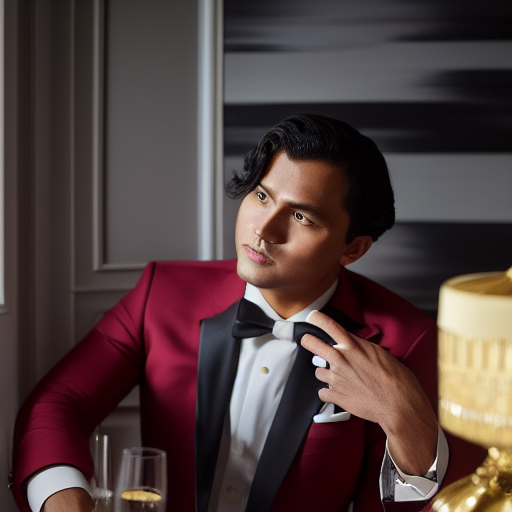

In [5]:
print("\nDisplaying Final Generated Image:")    

Image.fromarray(final_image_np)


Plotting Intermediate Denoising Steps...


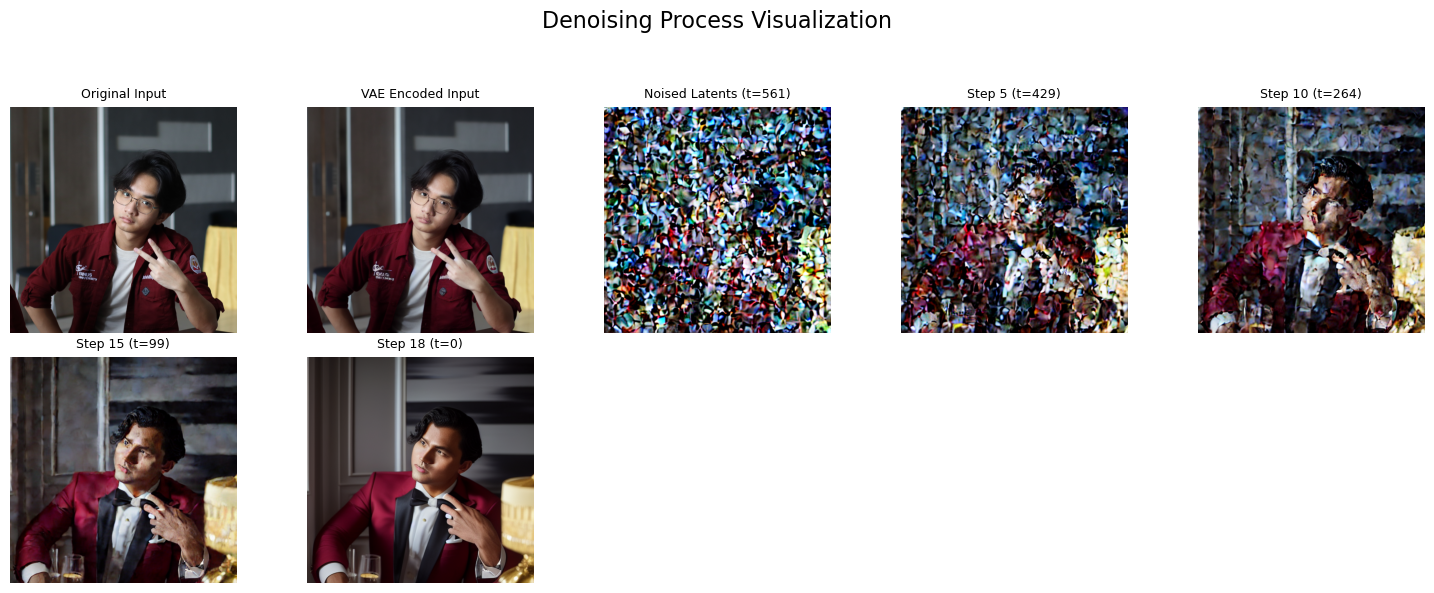


Generation and visualization complete.


In [6]:
# Plotting intermediate images
if intermediate_images:
    print("\nPlotting Intermediate Denoising Steps...")
    num_viz_steps = len(intermediate_images)
    
    # Determine layout for plotting (e.g., max 4-5 images per row)
    cols_plot = min(num_viz_steps, 5)
    rows_plot = math.ceil(num_viz_steps / cols_plot)

    plt.figure(figsize=(cols_plot * 3, rows_plot * 3)) # Adjusted figsize
    for i, pil_img in enumerate(intermediate_images):
        plt.subplot(rows_plot, cols_plot, i + 1)
        plt.imshow(pil_img)
        plt.title(viz_labels[i], fontsize=9)
        plt.axis('off')
    
    plt.suptitle("Denoising Process Visualization", fontsize=16, y=1.0 if rows_plot > 1 else 1.02)
    plt.tight_layout(rect=[0, 0.02, 1, 0.95 if rows_plot > 1 else 0.93]) # Adjust rect for suptitle
    plt.show()

print("\nGeneration and visualization complete.")

In this plot you can see clearly the denoising step on diffrent timestep rather than before in the same timestep you couldnt notice any diffrence

### Text to Image Example

c:\Users\Lenovo\.conda\envs\stable_diff_model\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


100%|██████████| 50/50 [08:08<00:00,  9.76s/it]


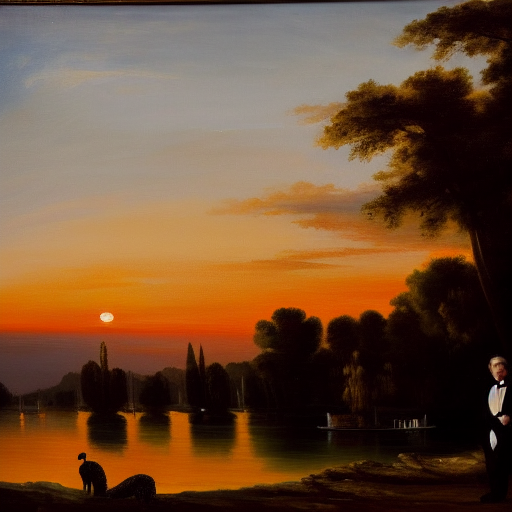

In [ ]:
DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
model_file = "../data/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

## TEXT TO IMAGE

# prompt = "A dog with sunglasses, wearing comfy hat, looking at camera, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
prompt = "Oil painting of a handsome, wealthy man wearing a black and white suit with a tie, with a background of a luxurious modern villa during sunset. The scene is elegant, cinematic, and detailed, with rich warm colors and artistic brushstrokes typical of classical oil paintings."
uncond_prompt = "blurry, low quality, cartoon, text, signature, watermark, ugly, deformed, distorted face, unrealistic proportions, pixelated, oversaturated, poorly drawn"  # Also known as negative prompt like not wanted to have some characteristics
do_cfg = True
cfg_scale = 10  # min: 1, max: 14

## IMAGE TO IMAGE

input_image = None
# Comment to disable image to image
# image_path = "../images/ariel.jpg"
# input_image = Image.open(image_path)

# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.5 # range 0 - 1

## SAMPLER

sampler = "ddpm"
num_inference_steps = 50
seed = 42

output_image = pipeline.generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)

I just copy the codfe from demo.ipynb so that this ipynb cover everything, in this case i just show the process if its only accept text prompt as the only input. 

## IV. Some Key Concept from The Youtube Video

### Classifier-Free Guidance (CFG)

Classifier-Free Guidance (CFG) enhances prompt adherence in text-to-image models by directing the generation process more assertively towards the provided text. It operates by obtaining two noise predictions from the U-Net, one conditioned on the text and another unconditionally—and then extrapolating towards the conditional prediction using a guidance scale (cfg_scale). This method allows adjustable control over how strongly the output reflects the prompt, balancing fidelity with potential creative variation without needing an auxiliary classifier.

### Latent Diffusion

Latent Diffusion optimizes high-resolution image synthesis by performing the computationally demanding diffusion and denoising operations within a compressed latent space. A Variational Autoencoder (VAE) first encodes the image into this lower-dimensional space where the U-Net operates; subsequently, the VAE decoder reconstructs the image from the denoised latent representation. This approach substantially reduces computational costs and memory usage, enabling the efficient generation of large-scale images.

### Role of Attention Mechanisms

Attention mechanisms are pivotal for information integration in these models. Self-attention, within both text encoders like CLIP and the image-generating U-Net, allows elements (text tokens or image patches) to weigh the significance of other elements within their own sequence, thereby capturing internal context. Cross-attention, specifically within the U-Net, is crucial for conditioning image synthesis on text by enabling image features to selectively draw information from the text prompt's embeddings, ensuring textual concepts guide visual generation.